# Extracting Drug-drug Interactions from Biomedical Texts using Knowledge Graph Embeddings and Multi-focal Loss

Our work aims to reproduce the paper ”Extract ing Drug-drug Interactions from biomedical texts using Knowledge graph embeddings and Multifocal Loss ” (Jin et al., 2022). Specifically, we will rebuild the proposed framework for DDI classification, attempt to reproduce the evaluation results, and do the ablation experiments.

We verified the main claims of the paper:
1. Claim 1- Novel DDI classification framework produce state of art result of 0.86 (F-score) :Our experiment results show a micro-F-score of 0.84  which is approximately 0.0224 less than what is claimed by the paper (86.24).Since a previous paper (Mondal, 2020) achieved 0.84, we are unable to conclude that the novel framework proposed in the paper provide state of the art results.
2. Claim 2 - Novel Framework complements BERT based embedding with knowledge graph embedding :Framework successfully complemented language feature with drug Knowledge Graph . After adding drug knowledge embedding, recall increased by 0.03 and f-score increased by 0.01
3. Claim 3 - KGE-MFL alleviated the problem of imbalance in dataset : MFL (F-score= 0.84) was able perform better than cross entropy loss function (F-score= 0.78) for the imbalanced DDI extraction dataset.


## Initial Setup

### This entire step needs to be ran only once.
*In case of errors, delete the corresponding folder in the working directory.*

Install necessary libraries using pip, in case of errors, please comsult the respective documentation for installation.

In [ ]:
!pip install -q matplotlib numpy pandas Requests scikit_learn stanza torch tqdm transformers
print("success!")

success!


Download the data and embeddings from the paper's authors.

In [ ]:
import os
import requests
import zipfile
from io import BytesIO
import platform
import shutil

def getGithubFolder(repo_url, branch, repo_name, folder_name):
    if not os.path.exists(folder_name):
        zip_url = f"{repo_url}/archive/refs/heads/{branch}.zip"

        try:
            response = requests.get(zip_url, timeout=(5, None))
        except requests.exceptions.Timeout as err:
            print(err)

        with zipfile.ZipFile(BytesIO(response.content)) as zf:
            for member in zf.infolist():
                if member.filename.startswith(f"{repo_name}/{folder_name}/"):
                    zf.extract(member)

        if platform.system() == "Windows":
            shutil.move(os.path.join(repo_name, folder_name), folder_name)
            shutil.rmtree(repo_name)
        else:
            os.rename(f"{repo_name}/{folder_name}", folder_name)
            os.system(f"rm -r {repo_name}")

        print(f"\"{folder_name}\" folder created.")

    else:
        print(f"\"{folder_name}\" folder already exists.")


getGithubFolder("https://github.com/NWU-IPMI/DDIE-KGE-MFL", "master", "DDIE-KGE-MFL-master", "data")
getGithubFolder("https://github.com/NWU-IPMI/DDIE-KGE-MFL", "master", "DDIE-KGE-MFL-master", "embedding")

"data" folder already exists.
"embedding" folder already exists.


This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in 'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'

In [ ]:
def getFile(url):
    file_name = url.split('/').pop()
    if not os.path.exists(file_name):

        try:
            response = requests.get(url, timeout=(5, None))
        except requests.exceptions.Timeout as err:
            print(err)

        with open(file_name, "wb") as f:
            f.write(response.content)
            print(f"\"{file_name}\" created.")
    else:
        print(f"\"{file_name}\" already exists.")

getFile("https://raw.githubusercontent.com/NWU-IPMI/DDIE-KGE-MFL/master/MultiFocalLoss.py")

"MultiFocalLoss.py" already exists.


Import and download stanza.

In [ ]:
import stanza
stanza.download('en', package='craft', model_dir="stanza_resources")

2023-05-08 23:21:42 INFO: Downloading these customized packages for language: en (English)...
| Processor | Package |
-----------------------
| tokenize  | craft   |
| pos       | craft   |
| lemma     | craft   |
| depparse  | craft   |
| pretrain  | craft   |

2023-05-08 23:21:42 INFO: File exists: stanza_resources\en\tokenize\craft.pt
2023-05-08 23:21:42 INFO: File exists: stanza_resources\en\pos\craft.pt
2023-05-08 23:21:42 INFO: File exists: stanza_resources\en\lemma\craft.pt
2023-05-08 23:21:42 INFO: File exists: stanza_resources\en\depparse\craft.pt
2023-05-08 23:21:43 INFO: File exists: stanza_resources\en\pretrain\craft.pt
2023-05-08 23:21:43 INFO: Finished downloading models and saved to stanza_resources.


# Create Drug-drug interaction dataset


Import the necessary libraries, use pip if anything fails. The notebook was developed with Google Collab and Conda enviornemnts in mind.

In [ ]:
import os
import csv
import pickle
import stanza
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, cuda
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel
from typing import List
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from MultiFocalLoss import MultiFocalLoss

Seed all random variables.

In [ ]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)

Set cuda or cpu as the device depending on the machine configuration.

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
print("Your device is: " + device)

Your device is: cuda


Load Drug-drug interaction(DDI) data (Preprocessed)

In [ ]:
entities_dict = {}
with open("data/entities.dict", 'r', encoding='utf-8') as fr:
    lines = csv.reader(fr, delimiter='\t')
    for line in lines:
        idx = line[0]
        entity = line[1]
        entities_dict[entity] = int(idx)
drug_embedding = np.load("./embedding/entity_embedding.npy", allow_pickle=True)
train_df = pd.read_csv("data/train.tsv", delimiter="\t", header=None)
test_df = pd.read_csv("data/test.tsv", delimiter="\t", header=None)

with pd.option_context('expand_frame_repr', False):
    print(f"Loaded entities dict with {len(entities_dict)} tokens.")
    print(f"Loaded drug embeddings with {drug_embedding.shape[0]} entries")
    print(f"Loaded training data with {train_df.shape[0]} entries.")
    print(f"Loaded test data with {test_df.shape[0]} entries.")

Loaded entities dict with 7135 tokens.
Loaded drug embeddings with 7135 entries
Loaded training data with 22710 entries.
Loaded test data with 4615 entries.


Visualization of the dataset statistics

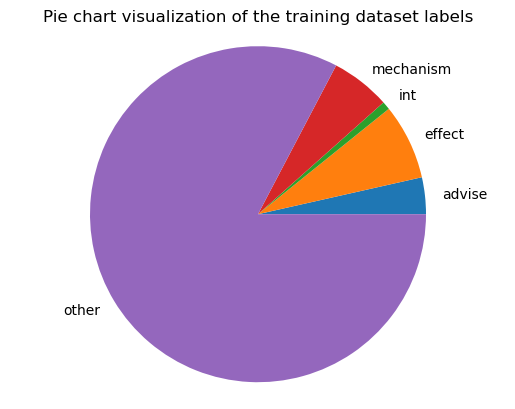

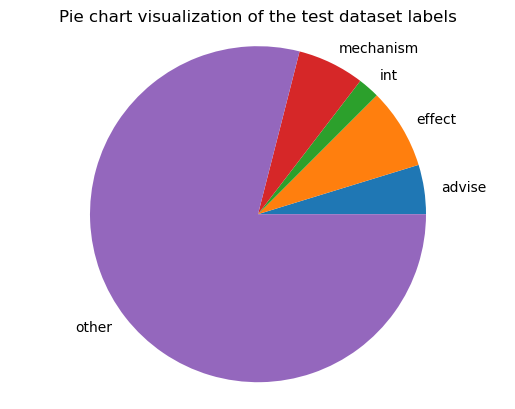

In [ ]:
# Generate Pie chart for train dataset
df = train_df.groupby([0])[0].count()
plt.pie(df,labels=df.index)
plt.axis('equal')
plt.title('Pie chart visualization of the training dataset labels')
plt.show()

# Generate Pie chart for test dataset
df = test_df.groupby([0])[0].count()
plt.pie(df,labels=df.index)
plt.axis('equal')
plt.title('Pie chart visualization of the test dataset labels')
plt.show()

Functions for key-path creation.

In [ ]:
nlp = stanza.Pipeline('en', processors='tokenize,pos,lemma,depparse', download_method=None)

def get_path_to_root(sentence, idx):
    path = [idx]
    while sentence.words[idx - 1].head != 0:
        idx = sentence.words[idx - 1].head
        path.append(idx)
    return path


def find_lca(sentence, drug1_idx, drug2_idx):
    path1 = get_path_to_root(sentence, drug1_idx)
    path2 = get_path_to_root(sentence, drug2_idx)
    for node1 in path1:
        if node1 in path2:
            return node1


def extract_key_path(sentence, drug1_idx, drug2_idx):
    lca = find_lca(sentence, drug1_idx, drug2_idx)
    key_path = []

    def add_path_to_lca(idx, lca, key_path):
        while idx != lca:
            key_path.append(idx)
            idx = sentence.words[idx - 1].head
        return key_path

    key_path = add_path_to_lca(drug1_idx, lca, key_path)
    key_path = add_path_to_lca(drug2_idx, lca, key_path)

    key_path.append(lca)
    key_path = list(set(key_path))

    return key_path


def key_path_feature_vector(key_path: List[int], sentence):
    # For simplicity, we use the count of each POS tag in the key path as features
    pos_counts = {}
    for idx in key_path:
        pos = sentence.words[idx - 1].upos
        if pos not in pos_counts:
            pos_counts[pos] = 0
        pos_counts[pos] += 1

    all_pos_tags = ["ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
    feature_vector = [pos_counts.get(tag, 0) for tag in all_pos_tags]

    return torch.tensor(feature_vector, dtype=torch.float32)

2023-05-08 23:21:44 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-05-08 23:21:44 INFO: Using device: cuda
2023-05-08 23:21:44 INFO: Loading: tokenize
2023-05-08 23:21:46 INFO: Loading: pos
2023-05-08 23:21:46 INFO: Loading: lemma
2023-05-08 23:21:47 INFO: Loading: depparse
2023-05-08 23:21:47 INFO: Done loading processors!


Create a CustomDataset for DDI data

In [ ]:
ddi_labels = ['other', 'mechanism', 'effect', 'advise', 'int']
label_mapping = {label: idx for idx, label in enumerate(ddi_labels)}


class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, drug2Id, drug_embedding, cache_file=None):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.drug2Id = drug2Id
        self.drug_embedding = drug_embedding

        # load data from cache if possible
        if cache_file is not None and os.path.exists(cache_file):
            print(f"Reading from cache file at {cache_file}")
            with open(cache_file, "rb") as f:
                self.preloaded_data = pickle.load(f)
        else:
            self.preloaded_data = []
            for index in tqdm(range(len(data)), desc="Loading data", leave=True):

                text = self.data.iloc[index][1].replace('<e1>', '').replace('</e1>', '').replace('<e2>', '').replace('</e2>', '')

                label_str = self.data.iloc[index][0]
                label = label_mapping[label_str]
                drug1 = self.data.iloc[index][2]
                drug1Id = self.drug2Id[drug1]
                drug1Embedding = self.drug_embedding[drug1Id]
                drug2 = self.data.iloc[index][3]
                drug2Id = self.drug2Id[drug2]
                drug2Embedding = self.drug_embedding[drug2Id]

                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    padding='max_length',
                    truncation=True,
                    return_token_type_ids=True,
                    return_tensors='pt'
                )

                ### DRUG POSITIONS ###
                # Tokenize drug names
                drug1_tokens = self.tokenizer.tokenize("DRUG1")
                drug2_tokens = self.tokenizer.tokenize("DRUG2")
                # Find positions of drug entities
                input_tokens = self.tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())
                drug1_position = self.find_entity_position(input_tokens, drug1_tokens)
                drug2_position = self.find_entity_position(input_tokens, drug2_tokens)
                if drug1_position == -1 or drug2_position == -1:
                    print(f"Error at index {index} in the data set. Reported by tokenizer. Skipping.")
                    print(drug1_position, drug2_position)
                    print(text)
                    continue

                ### KEY-PATH WITH STANZA ###
                doc = nlp(text)
                key_path_feature = None
                for sentence in doc.sentences:
                    drug1_position_stanza = self.find_entity_position_stanza(sentence, "DRUG1")
                    drug2_position_stanza = self.find_entity_position_stanza(sentence, "DRUG2")
                    # Check if both DRUG1 and DRUG2 are found in the current sentence
                    if drug1_position_stanza != -1 and drug2_position_stanza != -1:
                        # Get key path
                        key_path = extract_key_path(sentence, drug1_position_stanza, drug2_position_stanza)
                        key_path_feature = key_path_feature_vector(key_path, sentence)
                        # Stop searching, as both DRUG1 and DRUG2 have been found
                        break
                if key_path_feature is None:
                    key_path_feature = torch.zeros(17, dtype=torch.float32)

                text = text.replace("DRUG1", drug1)
                text = text.replace("DRUG2", drug2)

                self.preloaded_data.append({
                    "text": text,
                    "input_ids": encoding["input_ids"],
                    "attention_mask": encoding["attention_mask"],
                    "token_type_ids": encoding["token_type_ids"],
                    "label": torch.tensor(label, dtype=torch.long),
                    "drug1Emb": torch.from_numpy(drug1Embedding),
                    "drug2Emb": torch.from_numpy(drug2Embedding),
                    "drug1_position": torch.tensor(drug1_position, dtype=torch.int),
                    "drug2_position": torch.tensor(drug2_position, dtype=torch.int),
                    "key_path_feature": key_path_feature
                })
            if cache_file is not None:
                print(f"Writing to cache file at {cache_file}")
                with open(cache_file, "wb") as f:
                    pickle.dump(self.preloaded_data, f)

    def __len__(self):
        return len(self.preloaded_data)

    def __getitem__(self, index):
        return self.preloaded_data[index]

    def find_entity_position(self, input_tokens, entity_tokens):
        for i in range(len(input_tokens) - len(entity_tokens) + 1):
            if input_tokens[i:i + len(entity_tokens)] == entity_tokens:
                return i
        return -1

    def find_entity_position_stanza(self, sentence, entity):
        for i, word in enumerate(sentence.words):
            if word.text == entity:
                return i + 1
        return -1

Create Training and Test dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
tokenizer.add_special_tokens({"additional_special_tokens": ["<e1>", "</e1>", "<e2>", "</e2>"]})

max_len = 390

print("Loading training dataset:")
train_dataset = CustomDataset(train_df, tokenizer, max_len, entities_dict, drug_embedding, cache_file="train.cache")
print("Loading test dataset:")
test_dataset = CustomDataset(test_df, tokenizer, max_len, entities_dict, drug_embedding, cache_file="test.cache")

train_size = 32
test_size = 16

train_params = {'batch_size': train_size,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': test_size,
               'shuffle': True,
               'num_workers': 0
               }

training_loader = DataLoader(train_dataset, **train_params)
testing_loader = DataLoader(test_dataset, **test_params)

Loading training dataset:
Reading from cache file at train.cache
Loading test dataset:
Reading from cache file at test.cache



# Create DDI classifier model

In [ ]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.0, use_activation=True):
        super(FCLayer, self).__init__()
        self.use_activation = use_activation
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.dropout(x)
        if self.use_activation:
            x = self.activation(x)
        return self.linear(x)


class BertDDIClassifier(torch.nn.Module):
    def __init__(self):
        super(BertDDIClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
        for param in self.bert.parameters():
            param.requires_grad = True
        self.bert.resize_token_embeddings(len(tokenizer))
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = nn.Linear(2000, 200)
        self.classifier = torch.nn.Linear(768, 5)
        self.bert_layer_weights = nn.Parameter(torch.rand(13, 1))
        self.key_path_lstm = nn.LSTM(input_size=17, hidden_size=768, num_layers=1, batch_first=True, dropout=0.5, bidirectional=True)
        self.key_path_linear = nn.Linear(768 * 2, 768)
        self.MLP1 = FCLayer((768 + 200) * 2, 768, 0.3)

    def forward(self, input_ids, attention_mask, token_type_ids, drug1Embs, drug2Embs, drug1_position, drug2_position, key_path_feature, return_latent_space=False):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)

        # position feature
        position_feature = torch.abs(drug1_position - drug2_position).unsqueeze(1).to(device)
        position_feature = position_feature / input_ids.shape[1]

        # lanaguage feature
        hidden_states = torch.stack(output[2])  # [13,Batch, 200, 768]
        hidden_states = hidden_states[:, :, :1, :]  # [13,Batch,1,768] # Select embedding for CLS token (1st token)
        weighted_bert_layers = hidden_states * self.bert_layer_weights.view(13, 1, 1, 1)  # [13, Batch ,1 , 768]
        summed = torch.sum(weighted_bert_layers, (2, 3))  # [13,Batch]
        summed = torch.permute(summed, [1, 0])  # [Batch,13]
        bert_layer_attn = torch.nn.functional.softmax(summed, dim=1)  # [Batch, 13]
        hidden_states = torch.permute(hidden_states, [1, 0, 2, 3])  # [Batch, 13,1,768]
        language_feature = hidden_states * bert_layer_attn.view(bert_layer_attn.shape[0], bert_layer_attn.shape[1], 1, 1)
        language_feature = torch.sum(language_feature, (2, 1))  # [Batch,768]

        # key-path feature
        key_path_feature = key_path_feature.unsqueeze(1)
        lstm_output, _ = self.key_path_lstm(key_path_feature)
        key_path_feature = lstm_output.squeeze(1)
        key_path_feature = self.key_path_linear(key_path_feature)

        # synthetical feature
        pooled_output = (position_feature + language_feature + key_path_feature) / 3

        # knowledege feature
        drug1 = self.linear(drug1Embs)
        drug2 = self.linear(drug2Embs)

        # final
        pooled_output = torch.cat([output.pooler_output, pooled_output, drug1, drug2], dim=1)

        if return_latent_space:
            return pooled_output

        pooled_output = self.MLP1(pooled_output)
        logits = self.classifier(self.dropout(pooled_output))
        return logits


model = BertDDIClassifier()
model.to(device)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\alyosharomanov\anaconda3\envs\DDIE-KGE-MFL\lib\site-packages\torch\nn\

BertDDIClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30526, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

# Training

Initialize loss function with weights.

In [ ]:
lossfn = MultiFocalLoss(len(ddi_labels), [0.8, 0.07, 0.08, 0.04, 0.01])

Set number of epochs.

In [ ]:
epochs = 6 if device == "cuda" else 1

Initialize schedule with warmup.

In [ ]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5, eps=1e-8)
t_total = len(training_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=t_total)

print(f"Total training steps (for scheduler): {t_total}")

Total training steps (for scheduler): 4260


DDI compute metrics

In [ ]:
def ddi_compute_metrics(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    p, r, f, s = precision_recall_fscore_support(y_pred=preds, y_true=labels, labels=[1, 2, 3, 4], average='micro')
    result = {
        "Precision": p,
        "Recall": r,
        "microF": f
    }
    return result

Training loop

In [ ]:
def train(epoch):
    model.train()
    losses = []

    for _, data in enumerate(tqdm(training_loader, desc=f"Epoch {epoch}/{epochs}", leave=True), 0):
        ids = data['input_ids'].to(device, dtype=torch.long).squeeze()
        mask = data['attention_mask'].to(device, dtype=torch.long).squeeze()
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long).squeeze()
        labels = data['label'].to(device, dtype=torch.long)
        drug1Embs = data['drug1Emb'].to(device, dtype=torch.float32)
        drug2Embs = data['drug2Emb'].to(device, dtype=torch.float32)
        drug1_position = data['drug1_position'].to(device, dtype=torch.int)
        drug2_position = data['drug2_position'].to(device, dtype=torch.int)
        key_path_feature = data['key_path_feature'].to(device, dtype=torch.float32)
        output = model(ids, mask, token_type_ids, drug1Embs, drug2Embs, drug1_position, drug2_position, key_path_feature)

        optimizer.zero_grad()
        loss = lossfn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return sum(losses) / len(losses)

Evaluate loop

In [ ]:
def evaluate(epoch):
    model.eval()
    outputs = []
    labels = []
    val_losses = []
    latent_space = []

    with torch.no_grad():
        for _, data in enumerate(tqdm(testing_loader, desc=f"Evaluating {epoch}/{epochs}", leave=True), 0):
            ids = data['input_ids'].to(device, dtype=torch.long).squeeze()
            mask = data['attention_mask'].to(device, dtype=torch.long).squeeze()
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long).squeeze()
            label = data['label'].to(device, dtype=torch.long)
            drug1Embs = data['drug1Emb'].to(device, dtype=torch.float32)
            drug2Embs = data['drug2Emb'].to(device, dtype=torch.float32)
            drug1_position = data['drug1_position'].to(device, dtype=torch.int)
            drug2_position = data['drug2_position'].to(device, dtype=torch.int)
            key_path_feature = data['key_path_feature'].to(device, dtype=torch.float32)
            output = model(ids, mask, token_type_ids, drug1Embs, drug2Embs, drug1_position, drug2_position, key_path_feature)

            latent_vectors = model(ids, mask, token_type_ids, drug1Embs, drug2Embs, drug1_position, drug2_position, key_path_feature, return_latent_space=True)
            latent_space.append(latent_vectors.cpu().numpy())

            val_loss = lossfn(output, label)
            val_losses.append(val_loss.item())
            outputs.append(output)
            labels.append(label)
        latent_space = np.vstack(latent_space)

    return torch.cat(outputs, 0), torch.cat(labels, 0), sum(val_losses) / len(val_losses), latent_space

Train

In [ ]:
print("Training...")
print(f"Number of Epochs: {epochs}")
print(f"Train samples: {len(train_dataset)}")
print(f"Train batch size: {train_size}")
print(f"Eval samples: {len(test_dataset)}")
print(f"Eval batch size: {test_size}")

all_train_losses, all_eval_losses, all_results = [], [], []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    all_train_losses.append(train_loss)

    outputs, labels, eval_loss, _ = evaluate(epoch)
    all_eval_losses.append(eval_loss)

    ddimetrics = ddi_compute_metrics(preds=torch.argmax(outputs, dim=1), labels=labels)
    all_results.append(ddimetrics)

    print(f"Metrics for Epoch {epoch} = {ddimetrics}")
    print(f"Train Loss: {train_loss}")
    print(f"Eval Loss: {eval_loss}")

Training...
Number of Epochs: 6
Train samples: 22710
Train batch size: 32
Eval samples: 4615
Eval batch size: 16


Evaluating 1/6: 100%|████████████████████████████████████████████████████████████████| 289/289 [00:47<00:00,  6.07it/s]


Metrics for Epoch 1 = {'Precision': 0.7748478701825557, 'Recall': 0.7876288659793814, 'microF': 0.7811860940695297}
Train Loss: 0.08576441309021288
Eval Loss: 0.07001840669555416


Evaluating 2/6: 100%|████████████████████████████████████████████████████████████████| 289/289 [00:43<00:00,  6.58it/s]


Metrics for Epoch 2 = {'Precision': 0.775811209439528, 'Recall': 0.8134020618556701, 'microF': 0.7941620533467538}
Train Loss: 0.028096414538933304
Eval Loss: 0.06688281831489255


Evaluating 3/6: 100%|████████████████████████████████████████████████████████████████| 289/289 [00:43<00:00,  6.57it/s]


Metrics for Epoch 3 = {'Precision': 0.832271762208068, 'Recall': 0.8082474226804124, 'microF': 0.8200836820083682}
Train Loss: 0.018790982492205777
Eval Loss: 0.06282491227486521


Evaluating 4/6: 100%|████████████████████████████████████████████████████████████████| 289/289 [00:45<00:00,  6.28it/s]


Metrics for Epoch 4 = {'Precision': 0.7860696517412935, 'Recall': 0.8144329896907216, 'microF': 0.7999999999999999}
Train Loss: 0.012677453342508721
Eval Loss: 0.07327604648275672


Evaluating 5/6: 100%|████████████████████████████████████████████████████████████████| 289/289 [00:43<00:00,  6.64it/s]


Metrics for Epoch 5 = {'Precision': 0.8579610538373424, 'Recall': 0.7721649484536083, 'microF': 0.812805208898535}
Train Loss: 0.010166855729487868
Eval Loss: 0.07984050094246634


Evaluating 6/6: 100%|████████████████████████████████████████████████████████████████| 289/289 [00:43<00:00,  6.70it/s]

Metrics for Epoch 6 = {'Precision': 0.8511087645195353, 'Recall': 0.8309278350515464, 'microF': 0.8408972352634324}
Train Loss: 0.007608007194306685
Eval Loss: 0.07194845522488032


# Evaluation and Visualisation

In [ ]:
outputs, labels, val_losses, latent_space = evaluate(epoch)
ddimetrics = ddi_compute_metrics(preds=torch.argmax(outputs, dim=1), labels=labels)
print(f"Metrics = {ddimetrics}")

Evaluating 6/6: 100%|████████████████████████████████████████████████████████████████| 289/289 [00:44<00:00,  6.57it/s]

Metrics = {'Precision': 0.8511087645195353, 'Recall': 0.8309278350515464, 'microF': 0.8408972352634324}


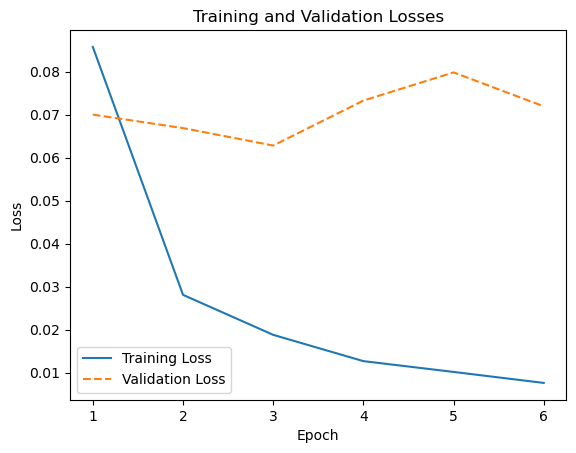

In [ ]:
epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, all_train_losses, label='Training Loss')
plt.plot(epochs_list, all_eval_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

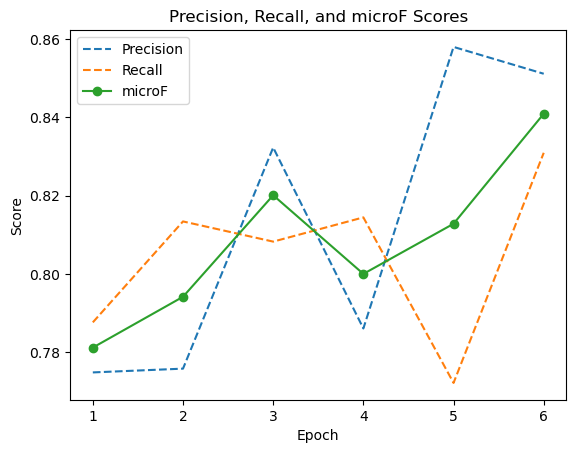

In [ ]:
precision = [d['Precision'] for d in all_results]
recall = [d['Recall'] for d in all_results]
microF = [d['microF'] for d in all_results]

plt.plot(epochs_list, precision, label='Precision', linestyle='--')
plt.plot(epochs_list, recall, label='Recall', linestyle='--')
plt.plot(epochs_list, microF, label='microF', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision, Recall, and microF Scores')
plt.legend()
plt.show()

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_latent_space_tsne = tsne.fit_transform(latent_space)

# PCA
pca = PCA(n_components=2)
reduced_latent_space_pca = pca.fit_transform(latent_space)

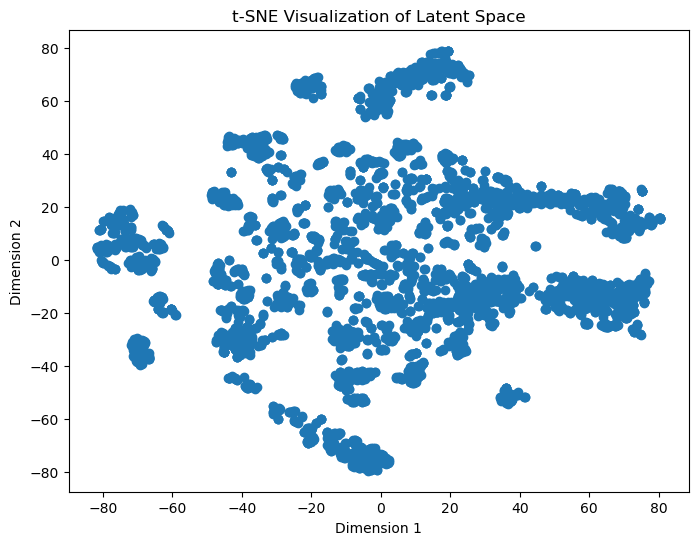

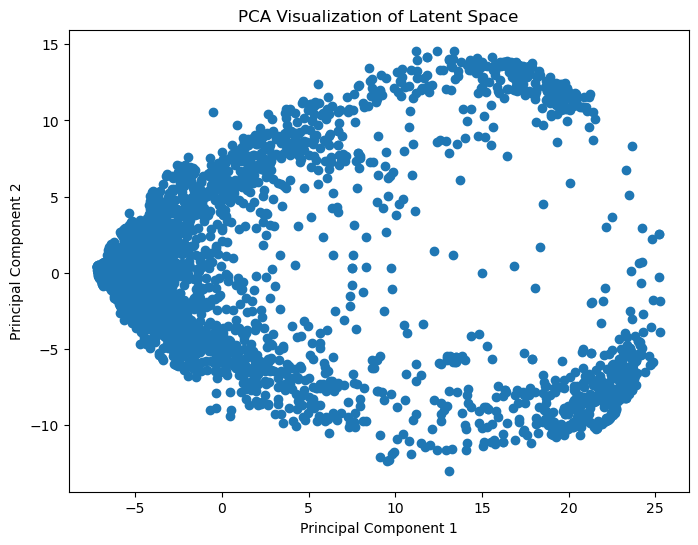

In [ ]:
# t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(reduced_latent_space_tsne[:, 0], reduced_latent_space_tsne[:, 1])
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# PCA
plt.figure(figsize=(8, 6))
plt.scatter(reduced_latent_space_pca[:, 0], reduced_latent_space_pca[:, 1])
plt.title("PCA Visualization of Latent Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Summary and Conclusion

Our experiment results show the a micro F-score
of 0.84 for DDI classification which is approxi-
mately 0.0224 less than what is claimed by the pa-
per (86.24).Since a previous paper (Mondal, 2020)
achieved 0.84, we are unable to conclude that novel
framework proposed in the paper provide state of
the art results on DDIExtraction 2013 dataset. Also
we observed that framework successfully comple-
mented language feature with Drug Knowledge
Graph . After adding drug knowledge
embedding, recall increased by 0.03 and microF
increased by 0.01. Also, As claimed by the paper,
MFL was able perform better than cross entropy
loss function for the imbalanced DDI extraction
dataset.

# References
Xin Jin, Xia Sun, Jiacheng Chen, and Richard Sutcliffe. 2022. Extracting Drug-drug Interactions from Biomedical Texts using Knowledge Graph Embeddings and Multi-focal Loss. In Proceedings of the 31st ACM International Conference on Information &amp; Knowledge Management (CIKM '22). Association for Computing Machinery, New York, NY, USA, 884–893. https://doi.org/10.1145/3511808.3557318

Gu, Y., Tinn, R., Cheng, H., Lucas, M.R., Usuyama, N., Liu, X., Naumann, T., Gao, J., & Poon, H. (2020). Domain-Specific Language Model Pretraining for Biomedical Natural Language Processing. ACM Transactions on Computing for Healthcare (HEALTH), 3, 1 - 23.

Lin, T., Goyal, P., Girshick, R.B., He, K., & Dollár, P. (2017). Focal Loss for Dense Object Detection. 2017 IEEE International Conference on Computer Vision (ICCV), 2999-3007.

